# Исследование технологического процесса очистки золота

Спрогнозировать концентрацию золота при проведении процесса очистки золота


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

## Подготовка данных

### Импорт данных

Возможные значения для блока [этап]:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

#### Обучающие данные

In [2]:
train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col = 'date')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

#### Тестовые данные

In [3]:
test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col = 'date')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

#### Полный датасет

In [4]:
df = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col = 'date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

### Проверка расчета эффективности обогащения

Вычислите  на обучающей выборке для признака rougher.output.recovery

#### Функция расчета

$$
Recovery = 100 * C*(F-T) / (F*(C-T))
$$
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для этапа флотации:
* C = rougher.output.concentrate_au
* F = rougher.input.feed_au
* T = rougher.output.tail_au

In [5]:
def calc_recovery(data, state = 'rougher'):
    c_field = state + '.output.concentrate_au'
    f_field = state + '.input.feed_au'
    t_field = state + '.output.tail_au'
    
    recovery = 100 * data[c_field] * (data[f_field] - data[t_field]) / (data[f_field] * (data[c_field] - data[t_field]))
    return recovery

#### Рассчитываем на обучающей выборке

In [6]:
train_rougher_mae = mean_absolute_error(train_df['rougher.output.recovery'], calc_recovery(train_df, state = 'rougher'))
print('MAE = ', train_rougher_mae)

MAE =  1.1498046842860452e-14


#### Вывод

* Ошибка очень мала. Расчет Recovery во входящих данных выполнен корректно

### Анализ признаков, не доступных в тестовой выборке

In [7]:
# Анализ разницы признаках
diff_columns = np.setdiff1d(train_df.columns, test_df.columns)
train_df[diff_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_au                         14149 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_au                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                            

Выводы:
* Нет recovery на финальной стадии final.output.recovery и стадии флотации rougher.output.recovery
* Нет информации по доли концентрата золота на финальном выходе в сырье final.output.concentrate_au и примесях final.output.tail_au
* Нет информации по доли концентрата золота на выходе стадии первичной очистки сырья primary_cleaner.output.concentrate_au и хвоста primary_cleaner.output.tail_au
* Нет информации по доли концентрата золота на выходе стадии флотации сырья rougher.output.concentrate_au  и хвоста rougher.output.tail_au
* Нет информации по доли концентрата золота на выходе стадии флотации вторичной очистки хвоста secondary_cleaner.output.tail_au


Данные можно взять из полного датасета




### Предобработка данных

#### Восстанавливаем тестовый датасет из полных данных

In [8]:
test_df[diff_columns] = df[diff_columns]
set(test_df.columns) == set(train_df.columns)

True

#### Обрабатываем пропуски

In [9]:
# Заполняем средними значениями своих показателей
print('Количество пропусков в обучающем наборе до обработки:', sum(train_df.isna().sum()))
print('Количество пропусков в тестовом наборе до обработки:', sum(test_df.isna().sum()))

for column in train_df.columns:
    train_df[column] = train_df[column].fillna(train_df[column].mean())
    test_df[column] = test_df[column].fillna(test_df[column].mean())
    
print('Количество пропусков в обучающем наборе после обработки:', sum(train_df.isna().sum()))
print('Количество пропусков в тестовом наборе после обработки:', sum(test_df.isna().sum()))

Количество пропусков в обучающем наборе до обработки: 4100
Количество пропусков в тестовом наборе до обработки: 381
Количество пропусков в обучающем наборе после обработки: 0
Количество пропусков в тестовом наборе после обработки: 0


#### Обрабатываем выбросы

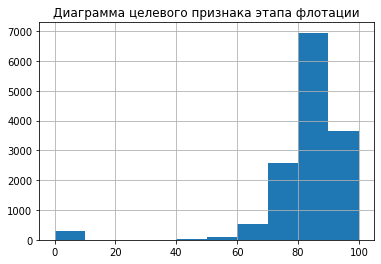

In [10]:
# Анализ значений целевого признака на разных стадиях
plt.title('Диаграмма целевого признака этапа флотации')
train_df['rougher.output.recovery'].hist();
plt.show()

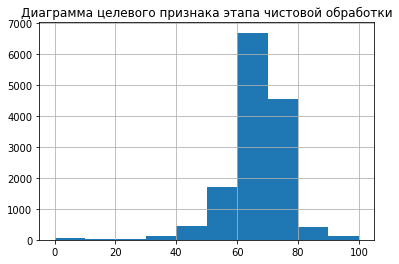

In [11]:
# Анализ значений целевого признака на разных стадиях
plt.title('Диаграмма целевого признака этапа чистовой обработки')
train_df['final.output.recovery'].hist();
plt.show()

In [12]:
# Удаление 0 значений
print('Нулевых записей до удаления: ', len(train_df.query('`rougher.output.recovery` == 0 or `final.output.recovery` == 0')))

train_df = train_df.query('`rougher.output.recovery` > 0 and `final.output.recovery` > 0')
test_df = train_df.query('`rougher.output.recovery` > 0 and `final.output.recovery` > 0')

print('Нулевых после после удаления: ', len(train_df.query('`rougher.output.recovery` == 0 or `final.output.recovery` == 0')))

Нулевых записей до удаления:  354
Нулевых после после удаления:  0


## Анализ данных

### Константы

In [13]:
# Этапы
STAGES = ('rougher', 'primary_cleaner', 'final')
STAGES_COLORS = ('yellow', 'green', 'red')

# Металлы
METALLS = ('ag', 'pb', 'sol', 'au')


### Анализ концентрации металлов на различных этапах очистки

#### Обучающая выборка

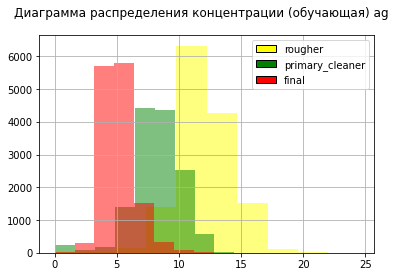

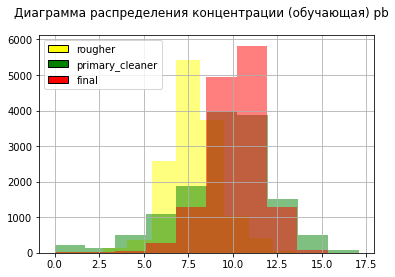

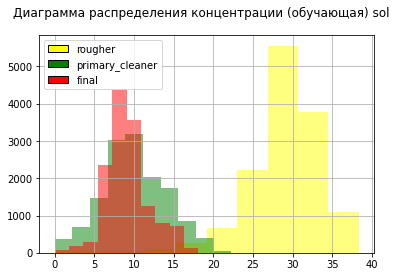

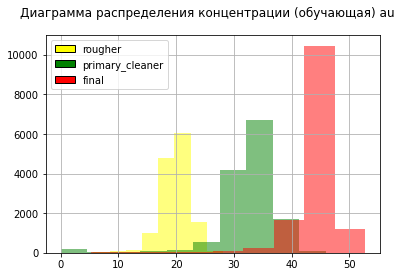

In [14]:
for met in METALLS:
    for stg_idx, stage in enumerate(STAGES):
        ax = train_df[f'{stage}.output.concentrate_{met}'].hist(alpha = 0.5, color=STAGES_COLORS[stg_idx])
    plt.suptitle(f"Диаграмма распределения концентрации (обучающая) {met}")
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in STAGES_COLORS]
    plt.legend(handles, STAGES)
    plt.show()


#### Тестовая выборка

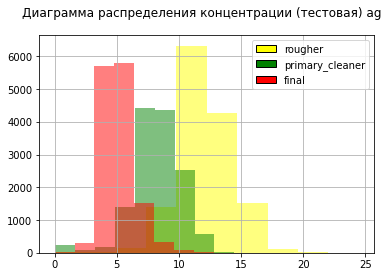

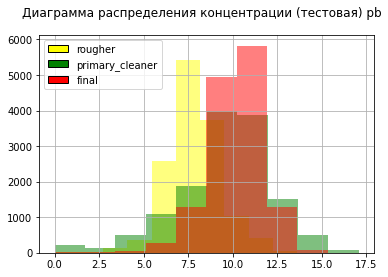

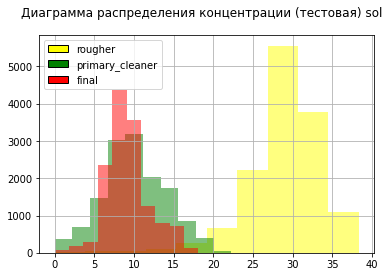

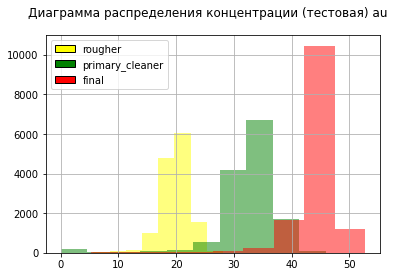

In [15]:
for met in METALLS:
    for stg_idx, stage in enumerate(STAGES):
        ax = test_df[f'{stage}.output.concentrate_{met}'].hist(alpha = 0.5, color=STAGES_COLORS[stg_idx])
    plt.suptitle(f"Диаграмма распределения концентрации (тестовая) {met}")
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in STAGES_COLORS]
    plt.legend(handles, STAGES)
    plt.show()


#### Выводы

* Концентрация серебра ag от начальной стадии обработки к финальной уменьшается
* Концентрация свинца pb практически не изменяется по стадиям обработки
* Концентрация солей sol существенно уменьшается на начальном этапе флотации. Далее не меняется
* Концентрация золота увеличивается с каждой стадией
* Распределения тестовой и обучающей выборки схожи

### Распределение размеров гранул сырья на обучающей и тестовой выборках

#### Гранулы входа этапа флотации

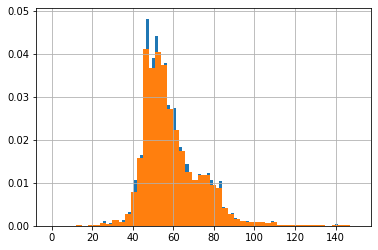

In [16]:
train_df['rougher.input.feed_size'].hist(bins=100, range=(0, 150), density = True)
test_df['rougher.input.feed_size'].hist(bins=50, range=(0, 150), density = True )
plt.show()

#### Гранулы входа этапа первичной очистки

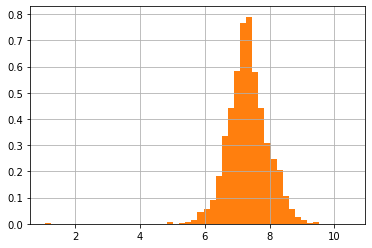

In [17]:
train_df['primary_cleaner.input.feed_size'].hist(bins=50, density = True)
test_df['primary_cleaner.input.feed_size'].hist(bins=50, density = True)
plt.show()

#### Выводы

Форма распределения тестовой и обучающей выборке похожи

### Суммарная концентрация всех веществ на разных стадиях

In [18]:
# Концентрация исходного сырья
base_feed = train_df['rougher.input.feed_pb'].sum() + train_df['rougher.input.feed_sol'].sum() + train_df['rougher.input.feed_au'].sum() + train_df['rougher.input.feed_ag'].sum()
rougher_feed = train_df['rougher.output.concentrate_ag'].sum() + train_df['rougher.output.concentrate_sol'].sum() + train_df['rougher.output.concentrate_au'].sum()  + train_df['rougher.output.concentrate_pb'].sum()
primary_cleaner_feed = train_df['primary_cleaner.output.concentrate_ag'].sum() + train_df['primary_cleaner.output.concentrate_sol'].sum() + train_df['primary_cleaner.output.concentrate_au'].sum()  + train_df['primary_cleaner.output.concentrate_pb'].sum()
final_cleaner_feed = train_df['final.output.concentrate_ag'].sum() + train_df['final.output.concentrate_sol'].sum() + train_df['final.output.concentrate_au'].sum()  + train_df['final.output.concentrate_pb'].sum()

print('Концентрация исходного сырья', base_feed)
print('Концентрация сырья после стадии флотации (черновой)', rougher_feed)
print('Концентрация сырья после стадии первичной очистки', primary_cleaner_feed)
print('Концентрация сырья после стадии вторичной очистки (финальная)', final_cleaner_feed)



Концентрация исходного сырья 776087.9479381556
Концентрация сырья после стадии флотации (черновой) 946625.0932117405
Концентрация сырья после стадии первичной очистки 830969.4879899656
Концентрация сырья после стадии вторичной очистки (финальная) 948547.5607576349


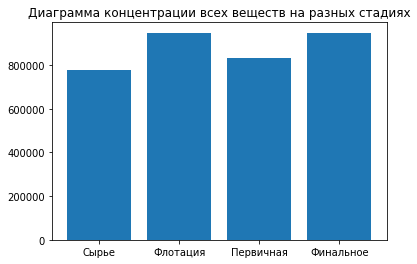

In [19]:
# Диаграмма
x =['Сырье','Флотация','Первичная','Финальное']
y = [base_feed, rougher_feed, primary_cleaner_feed, final_cleaner_feed]

plt.title('Диаграмма концентрации всех веществ на разных стадиях')
plt.bar(x, y);

* Суммарная концентрация веществ после стадии первичной обработки падает
* Итоговая суммарная концентрация веществ приблизительно соответсвует концентрации на стадии флотации

## Модель

Задача обучения с учителем - регрессия. Прорабатываем модели случайного леса и линейной регрессии

### Функция sMAPE

In [20]:
def smape(target, predictions):
    assert len(target) == len(predictions), 'Массивы должны совпадать по размеру'
    
    target = target
    predictions = predictions
    
    score = 0
    n = len(target)
    for i in range(len(target)):
        score += abs(target[i]-predictions[i]) / ((abs(target[i]) + abs(predictions[i])) / 2)
    score = 100 * score / n
    return score


def smape_final(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75*final_smape

### Функция построения модели

In [21]:
def create_model(model, features_train, target_train, features_valid, target_valid, features_test, target_test):
    # Нормализация
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train, target_train)
    features_valid = scaler.transform(features_valid)
    features_test = scaler.transform(features_test)
    # Обучаем
    model.fit(features_train, target_train)

    # Предсказываем на валидационной выборке
    predictions_valid = model.predict(features_valid)
    
    # Рассчитываем метрику для валидационной выборки
    score_valid = smape(target_valid, predictions_valid)
    
    # Предсказываем на тестовой
    predictions_test = model.predict(features_test)
    # Рассчитываем метрику для тестовой выборки
    score_test = smape(target_test, predictions_test)
    
    return model, score_valid, score_test
    

### Модель линейной регрессии

#### Прогнозирование эффективности обогащения чернового концентрата

In [22]:
# код ревьюера
# задал random_state, так как падало с ошибкой
random_state = 12345

In [23]:
# Подготавливаем данные
rougher_train_df = train_df[[c for c in train_df.columns if 'rougher.' in c]]
rougher_test_df = test_df[[c for c in test_df.columns if 'rougher.' in c]]

# Выделение признаков и целевого признака
rougher_features_train = rougher_train_df.drop('rougher.output.recovery', axis=1)
rougher_target_train = rougher_train_df['rougher.output.recovery']

rougher_features_test = rougher_test_df.drop('rougher.output.recovery', axis=1)
rougher_target_test = rougher_test_df['rougher.output.recovery']

rougher_features_train, rougher_features_valid, rougher_target_train, rougher_target_valid = train_test_split(rougher_features_train, rougher_target_train, test_size=0.25, random_state=random_state)

# Создаем модель
model, rougher_score_valid, rougher_score_test = create_model(LinearRegression(), rougher_features_train, rougher_target_train, rougher_features_valid, rougher_target_valid, rougher_features_test, rougher_target_test)
print('Метрика sMAPE валидационной выборки чернового концентрата', rougher_score_valid, '%')
print('Метрика sMAPE тестовой выборки чернового концентрата', rougher_score_test, '%')

Метрика sMAPE валидационной выборки чернового концентрата 1.7658706315209707 %
Метрика sMAPE тестовой выборки чернового концентрата 1.7851689021719621 %


#### Прогнозирование эффективности обогащения финального концентрата

In [24]:
# Подготавливаем данные
final_train_df = train_df[[c for c in train_df.columns if 'final.' in c]]
final_test_df = test_df[[c for c in test_df.columns if 'final.' in c]]

# Выделение признаков и целевого признака
final_features_train = final_train_df.drop('final.output.recovery', axis=1)
final_target_train = final_train_df['final.output.recovery']

final_features_test = final_test_df.drop('final.output.recovery', axis=1)
final_target_test = final_test_df['final.output.recovery']

final_features_train, final_features_valid, final_target_train, final_target_valid = train_test_split(final_features_train, final_target_train, test_size=0.25, random_state=random_state)

# Создаем модель
model, final_score_valid, final_score_test = create_model(LinearRegression(), final_features_train, final_target_train, final_features_valid, final_target_valid, final_features_test, final_target_test)
print('Метрика sMAPE валидационной выборки финального этапа', final_score_valid, '%')
print('Метрика sMAPE тестовой выборки финального этапа', final_score_test, '%')

Метрика sMAPE валидационной выборки финального этапа 7.188006056845583 %
Метрика sMAPE тестовой выборки финального этапа 7.274268921819379 %


#### Расчет итогового sMAPE

In [25]:
smape_valid = smape_final(rougher_score_valid, final_score_valid)
print('Итоговое sMAPE валидационной выборки', smape_valid, '%')

smape_test = smape_final(rougher_score_test, final_score_test)
print('Итоговое sMAPE тестовой выборки', smape_test, '%')

Итоговое sMAPE валидационной выборки 5.83247220051443 %
Итоговое sMAPE тестовой выборки 5.901993916907525 %


### Модель случайного леса

In [26]:
random_state = 12345

#### Прогнозирование эффективности обогащения чернового концентрата

In [27]:
# Подготавливаем данные
rougher_train_df = train_df[[c for c in train_df.columns if 'rougher.' in c]]
rougher_test_df = test_df[[c for c in test_df.columns if 'rougher.' in c]]

# Выделение признаков и целевого признака
rougher_features_train = rougher_train_df.drop('rougher.output.recovery', axis=1)
rougher_target_train = rougher_train_df['rougher.output.recovery']

rougher_features_test = rougher_test_df.drop('rougher.output.recovery', axis=1)
rougher_target_test = rougher_test_df['rougher.output.recovery']

rougher_features_train, rougher_features_valid, rougher_target_train, rougher_target_valid = train_test_split(rougher_features_train, rougher_target_train, test_size=0.25, random_state=random_state)

# Создаем модель
model, rougher_score_valid, rougher_score_test = create_model(RandomForestRegressor(random_state=random_state), rougher_features_train, rougher_target_train, rougher_features_valid, rougher_target_valid, rougher_features_test, rougher_target_test)
print('Метрика sMAPE валидационной выборки чернового концентрата', rougher_score_valid, '%')
print('Метрика sMAPE тестовой выборки чернового концентрата', rougher_score_test, '%')

Метрика sMAPE валидационной выборки чернового концентрата 0.5718488889632767 %
Метрика sMAPE тестовой выборки чернового концентрата 0.32833136466131274 %


#### Прогнозирование эффективности обогащения финального концентрата

In [28]:
# Подготавливаем данные
final_train_df = train_df[[c for c in train_df.columns if 'final.' in c]]
final_test_df = test_df[[c for c in test_df.columns if 'final.' in c]]

# Выделение признаков и целевого признака
final_features_train = final_train_df.drop('final.output.recovery', axis=1)
final_target_train = final_train_df['final.output.recovery']

final_features_test = final_test_df.drop('final.output.recovery', axis=1)
final_target_test = final_test_df['final.output.recovery']

final_features_train, final_features_valid, final_target_train, final_target_valid = train_test_split(final_features_train, final_target_train, test_size=0.25, random_state=random_state)

# Создаем модель
model, final_score_valid, final_score_test = create_model(RandomForestRegressor(random_state=random_state), final_features_train, final_target_train, final_features_valid, final_target_valid, final_features_test, final_target_test)
print('Метрика sMAPE валидационной выборки финального этапа', final_score_valid, '%')
print('Метрика sMAPE тестовой выборки финального этапа', final_score_test, '%')

Метрика sMAPE валидационной выборки финального этапа 4.6314997655729035 %
Метрика sMAPE тестовой выборки финального этапа 2.5587926917694808 %


#### Расчет итогового sMAPE

In [29]:
smape_valid = smape_final(rougher_score_valid, final_score_valid)
print('Итоговое sMAPE валидационной выборки', smape_valid, '%')

smape_test = smape_final(rougher_score_test, final_score_test)
print('Итоговое sMAPE тестовой выборки', smape_test, '%')

Итоговое sMAPE валидационной выборки 3.6165870464204968 %
Итоговое sMAPE тестовой выборки 2.0011773599924387 %


#### Поиск оптимальных гиперпараметров

In [30]:
# parametrs = { 'n_estimators': range (50, 150, 10),
#               'max_depth': range (1,13, 2),
#               'min_samples_leaf': range (1,8),
#               'min_samples_split': range (2,10,2) }

# clf = RandomForestRegressor(random_state=random_state)
# grid = GridSearchCV(clf, parametrs, cv=5, verbose=10)
# grid.fit(rougher_features_train, rougher_target_train)
# grid.best_params_

### Кросс-валидация

Выбираем модель линейной регрессии, т.к. результаты со случайном лесом схожи на тестовой выборке, а сама модель проще и быстрее

#### Этап чернового концентрата

In [31]:
# Размер блока 5
sample_size = int(len(rougher_features_train)/5)

features = np.array(rougher_features_train)
target = np.array(rougher_target_train.to_numpy())

scores = []
for i in range(0, len(features), sample_size):
    rght_idx = len(features) if i+sample_size > len(features) else i+sample_size
    valid_indexes = np.array(range(i,rght_idx))
    all_indexes = np.array(range(0, len(features)))
    train_indexes = np.where(np.isin(all_indexes, valid_indexes, invert=True))[0]
   
    features_train = features[train_indexes]
    target_train =  target[train_indexes]
    
    features_valid = features[valid_indexes]
    target_valid = target[valid_indexes]
    
    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    score = smape(target_valid, predictions_valid)
    scores.append(score)
 
rougher_mean_score = np.array(scores).mean()
print('Средняя оценка качества модели этапа чернового концентрата (флотации) :', rougher_mean_score, '%')


Средняя оценка качества модели этапа чернового концентрата (флотации) : 1.5903537405863333 %


#### Этап финальной очистки концентрата

In [32]:
# Размер блока 5
sample_size = int(len(final_features_train)/5)

features = np.array(final_features_train)
target = np.array(final_target_train.to_numpy())

scores = []
for i in range(0, len(features), sample_size):
    rght_idx = len(features) if i+sample_size > len(features) else i+sample_size
    valid_indexes = np.array(range(i,rght_idx))
    all_indexes = np.array(range(0, len(features)))
    train_indexes = np.where(np.isin(all_indexes, valid_indexes, invert=True))[0]
   
    features_train = features[train_indexes]
    target_train =  target[train_indexes]
    
    features_valid = features[valid_indexes]
    target_valid = target[valid_indexes]
    
    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    score = smape(target_valid, predictions_valid)
    scores.append(score)
 
final_mean_score = np.array(scores).mean()
print('Средняя оценка качества модели этапа финального концентрата (флотации) :', final_mean_score, '%')


Средняя оценка качества модели этапа финального концентрата (флотации) : 7.166704431057286 %


#### Итоговый sMAPE

In [33]:
print('Итоговый показатель качества модели после кросс-валидации на обучающей выборке', smape_final(rougher_mean_score, final_mean_score), '%')

Итоговый показатель качества модели после кросс-валидации на обучающей выборке 5.772616758439548 %


## Общий вывод

* Проработаны несколько моделей машинного обучения для применимости в этой задаче
* Лучшие показатели sMAPE получила модель случайного леса
* Ошибки sMAPE метрики модели случайного леса составляет порядка 5.7%